<a href="https://colab.research.google.com/github/zhang-linnng/convex_restriction_transformed/blob/main/updated0830_projection_convexRestriction_case123nick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq libglpk-dev
!pip install cvxpy

In [43]:
!pip install pypower

# Import libraries

In [44]:
from __future__ import division
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from mpl_toolkits.mplot3d import Axes3D
import random
import pandas as pd
import math
import json
import pickle
import cmath
import sys

random.seed(1234321)

# Project folder

In [45]:
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        # Create a new directory if it does not exist
        os.makedirs(path)
        print("The new directory %s is created!" % (path))

In [46]:
project_path = "/content/gdrive/MyDrive/2023Projects/convex_restriction/case123nick/"
ourMethod_path = project_path  + "our_method/"
socp_path = project_path  + "socp/"
# sdp_path = project_path  + "sdp/"
newtonRaphson_path = project_path  + "newton_raphson/"
settings_path = project_path + "grid_case123nick/"

In [47]:
create_dir(settings_path)
create_dir(ourMethod_path)
create_dir(socp_path)
create_dir(newtonRaphson_path)

# Grid representation

## Parameters

In [48]:
import scipy.io as sio

# mat_contents = sio.loadmat(settings_path + mat_fname)
branch_contents = sio.loadmat(settings_path + 'branch_case123nick.mat')
bus_contents = sio.loadmat(settings_path + 'bus_case123nick.mat')
gen_contents = sio.loadmat(settings_path + 'gen_case123nick.mat')

print(branch_contents.keys())
print(bus_contents.keys())
print(gen_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'branch'])
dict_keys(['__header__', '__version__', '__globals__', 'bus'])
dict_keys(['__header__', '__version__', '__globals__', 'gen'])


In [49]:
## branch data: fbus(0), tbus(1), r(2), x(3), b(4)
## bus data: bus(0), type(1), Pd(2), Qd(3), Vmx(11), Vmn(12)
## gen data: bus(0), Pg(1), Qg(2), Qmax(3), Qmin(4), Pmax(8), Pmin(9)

branch_data = branch_contents['branch']
bus_data = bus_contents['bus']
gen_data = gen_contents['gen']

branch_array = np.concatenate([branch_data[:,0:1], branch_data[:,1:2], branch_data[:,2:3], branch_data[:,3:4], branch_data[:,4:5]], axis=1)
branch_df = pd.DataFrame(branch_array, columns = ['fbus','tbus','r','x','b'])
branch_df['fbus'] = branch_df['fbus'].apply(lambda x: int(x))
branch_df['tbus'] = branch_df['tbus'].apply(lambda x: int(x))

bus_array = np.concatenate([bus_data[:,0:1], bus_data[:,1:2], bus_data[:,2:3], bus_data[:,3:4], bus_data[:,11:12], bus_data[:,12:13]], axis=1)
bus_df = pd.DataFrame(bus_array, columns = ['bus','type','Pd','Qd','Vmx','Vmn'])
bus_df['bus'] = bus_df['bus'].apply(lambda x: int(x))
bus_df['type'] = bus_df['type'].apply(lambda x: int(x))

gen_array = np.concatenate([gen_data[:,0:1], gen_data[:,1:2], gen_data[:,2:3], gen_data[:,3:4], gen_data[:,4:5], gen_data[:,8:9], gen_data[:,9:10]], axis=1)
gen_df = pd.DataFrame(gen_array, columns = ['bus','Pg','Qg','Qmax','Qmin','Pmax','Pmin'])
gen_df['bus'] = gen_df['bus'].apply(lambda x: int(x))

In [50]:
branch_df = branch_df.sort_values(by=['fbus', 'tbus'], ascending=True)

In [51]:
branch_df.head()

,fbus,tbus,r,x,b
0,1,2,0.002546,0.002581,0.000003
1,1,3,0.003637,0.003687,0.000004
2,1,7,0.001502,0.003539,0.000006
3,3,4,0.002909,0.002949,0.000003
4,3,5,0.004728,0.004793,0.000005


In [52]:
gen_df.head()

,bus,Pg,Qg,Qmax,Qmin,Pmax,Pmin
0,114,0,0,200,-200,200,-200


In [53]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn
0,1,1,0.04,0.02,1.2,0.8
1,2,1,0.02,0.01,1.2,0.8
2,3,1,0.00,0.00,1.2,0.8
3,4,1,0.04,0.02,1.2,0.8
4,5,1,0.02,0.01,1.2,0.8


In [54]:
r_ij = branch_df["r"].to_numpy()
x_ij = branch_df["x"].to_numpy()
g_ij = r_ij/(r_ij**2+x_ij**2)
b_ij = x_ij/(r_ij**2+x_ij**2)
branch_df["conductance(g)"] = g_ij
branch_df["susceptance(b)"] = b_ij
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b)
0,1,2,0.002546,0.002581,0.000003,193.723868,196.391040
1,1,3,0.003637,0.003687,0.000004,135.606729,137.473712
2,1,7,0.001502,0.003539,0.000006,101.623767,239.402135
3,3,4,0.002909,0.002949,0.000003,169.508376,171.842151
4,3,5,0.004728,0.004793,0.000005,104.312855,105.749003


In [55]:
count_lines_df = branch_df.groupby(['fbus', 'tbus']).count()
count_lines_df.head()
branches = count_lines_df.index.to_list()
branches_list = [(int(x[0]), int(x[1])) for x in branches]
print(branches_list)

nodes = bus_df['bus'].to_list()
nodes_list = [int(x) for x in nodes]
print(nodes_list)

num_nodes = len(nodes_list)
num_branches = len(branches_list)
print('num_nodes:', num_nodes)
print('num_branches:', num_branches)

[(1, 2), (1, 3), (1, 7), (3, 4), (3, 5), (5, 6), (7, 8), (8, 9), (8, 12), (8, 13), (9, 14), (13, 18), (13, 34), (13, 52), (14, 10), (14, 11), (15, 16), (15, 17), (18, 19), (18, 21), (18, 35), (19, 20), (21, 22), (21, 23), (23, 24), (23, 25), (25, 26), (25, 28), (26, 27), (26, 31), (27, 33), (28, 29), (29, 30), (31, 32), (34, 15), (35, 36), (35, 40), (36, 37), (36, 38), (38, 39), (40, 41), (40, 42), (42, 43), (42, 44), (44, 45), (44, 47), (45, 46), (47, 48), (47, 49), (49, 50), (50, 51), (52, 53), (53, 54), (54, 55), (54, 57), (55, 56), (57, 58), (57, 60), (58, 59), (60, 62), (60, 67), (62, 63), (63, 64), (64, 65), (65, 66), (67, 68), (67, 72), (67, 97), (68, 69), (69, 70), (70, 71), (72, 73), (72, 76), (73, 74), (74, 75), (76, 77), (76, 86), (77, 78), (78, 79), (78, 80), (80, 81), (81, 82), (81, 84), (82, 83), (84, 85), (86, 87), (87, 88), (87, 89), (89, 90), (89, 91), (91, 92), (91, 93), (93, 94), (93, 95), (95, 96), (97, 98), (97, 101), (98, 99), (99, 100), (101, 102), (101, 105), (1

In [56]:
bus_to_numeric = dict()

for k in range(num_nodes):
    node_idx = nodes_list[k]
    bus_to_numeric[node_idx] = k

bus_to_neighbors = dict()
for edge in branches_list:
    fbus = edge[0]
    tbus = edge[1]
    if fbus not in bus_to_neighbors.keys():
        bus_to_neighbors[fbus] = [tbus]
    else:
        bus_to_neighbors[fbus] += [tbus]

    if tbus not in bus_to_neighbors.keys():
        bus_to_neighbors[tbus] = [fbus]
    else:
        bus_to_neighbors[tbus] += [fbus]

print('bus_to_numeric:', bus_to_numeric)
print('bus_to_neighbors:', bus_to_neighbors)


bus_to_numeric: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113}
bus_to_neighbors: {1: [2, 3, 7, 114], 2: [1], 3: [1, 4, 5], 7

In [57]:
numbering_links = dict()
for i in range(num_branches):
    fbus = branch_df.iloc[i, 0]
    tbus = branch_df.iloc[i, 1]
    numbering_links[i] = (fbus, tbus)
print('numbering_links:', numbering_links)

numbering_links: {0: (1, 2), 1: (1, 3), 2: (1, 7), 3: (3, 4), 4: (3, 5), 5: (5, 6), 6: (7, 8), 7: (8, 9), 8: (8, 12), 9: (8, 13), 10: (9, 14), 11: (13, 18), 12: (13, 34), 13: (13, 52), 14: (14, 10), 15: (14, 11), 16: (15, 16), 17: (15, 17), 18: (18, 19), 19: (18, 21), 20: (18, 35), 21: (19, 20), 22: (21, 22), 23: (21, 23), 24: (23, 24), 25: (23, 25), 26: (25, 26), 27: (25, 28), 28: (26, 27), 29: (26, 31), 30: (27, 33), 31: (28, 29), 32: (29, 30), 33: (31, 32), 34: (34, 15), 35: (35, 36), 36: (35, 40), 37: (36, 37), 38: (36, 38), 39: (38, 39), 40: (40, 41), 41: (40, 42), 42: (42, 43), 43: (42, 44), 44: (44, 45), 45: (44, 47), 46: (45, 46), 47: (47, 48), 48: (47, 49), 49: (49, 50), 50: (50, 51), 51: (52, 53), 52: (53, 54), 53: (54, 55), 54: (54, 57), 55: (55, 56), 56: (57, 58), 57: (57, 60), 58: (58, 59), 59: (60, 62), 60: (60, 67), 61: (62, 63), 62: (63, 64), 63: (64, 65), 64: (65, 66), 65: (67, 68), 66: (67, 72), 67: (67, 97), 68: (68, 69), 69: (69, 70), 70: (70, 71), 71: (72, 73), 72:

In [58]:
# incidence matrix
E = np.zeros((num_branches, num_nodes))
for m in range(num_branches):
    f_end = branch_df.iloc[m, 0]
    t_end = branch_df.iloc[m, 1]

    col1 = bus_to_numeric[f_end]
    col2 = bus_to_numeric[t_end]

    if col1 < col2:
        E[m, col1] = 1
        E[m, col2] = -1
    else:
        E[m, col1] = -1
        E[m, col2] = 1

print('E:', E)

E: [[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 1.  0.  0. ...  0.  0. -1.]]


In [59]:
gen_set_mask = bus_df['type']>1
gen_set = bus_df['bus'][gen_set_mask]
gen_rows = np.array(range(num_nodes))[gen_set_mask]
print('gen_set:\n', gen_set)
print('gen_rows:\n', gen_rows)

gen_set:
 113    114
Name: bus, dtype: int64
gen_rows:
 [113]


In [60]:
bus_lists = bus_df['bus'].to_numpy()
print(bus_lists.shape)
print(bus_lists)

(114,)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114]


In [61]:
branch_df['index'] = branch_df.index
branch_df.head()

b_for_lines = b_ij.reshape(-1,1)
g_for_lines = g_ij.reshape(-1,1)

##  Vectorize power flow equations

### Define matrices

In [62]:
G_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_a[row, col] = -g_ij[col]

            else: # if row < neighbor
                G_a[row, col] = -g_ij[col]


B_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_a[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_a[row, col] = b_ij[col]


print('G_a:', G_a.shape)
print('B_a:', B_a.shape)

G_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    G_hat[row, col] = g_ij[m]
    G_hat[col, row] = g_ij[m]

print('G_hat:', G_hat.shape)


d_active = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_active[row, 0] = np.sum(G_hat[row,:])

print('d_active:', d_active.shape)

A = np.block([
    G_a, B_a, d_active
])
print('A:', A.shape)

G_a: (114, 113)
B_a: (114, 113)
G_hat: (114, 114)
d_active: (114, 1)
A: (114, 227)


In [63]:
G_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_r[row, col] = g_ij[col]

            else: # if row < neighbor
                G_r[row, col] = -g_ij[col]


B_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_r[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_r[row, col] = -b_ij[col]


print('G_r:', G_r.shape)
print('B_r:', B_r.shape)


B_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    B_hat[row, col] = b_ij[m]
    B_hat[col, row] = b_ij[m]

print('B_hat:', B_hat.shape)

d_reactive = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_reactive[row, 0] = np.sum(B_hat[row,:])

print('d_reactive:', d_reactive.shape)

R = np.block([
    B_r, G_r, d_reactive
])
print('R:', R.shape)

G_r: (114, 113)
B_r: (114, 113)
B_hat: (114, 114)
d_reactive: (114, 1)
R: (114, 227)


### Power flow equations

In [64]:
def p_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active


def q_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

nominal_angle = np.zeros(num_nodes)
p = p_in_voltage(nominal_angle)
q = q_in_voltage(nominal_angle)
print(p)
print(q)

[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.68434189e-14]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.84217094e-14]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.0000000

## Nodal power bounds

In [65]:
bus_df['Pmax'] = bus_df['bus']
bus_df['Pmin'] = bus_df['Pd']
bus_df['Qmax'] = bus_df['Pd']
bus_df['Qmin'] = bus_df['Pd']
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.04,0.02,1.2,0.8,1,0.04,0.04,0.04
1,2,1,0.02,0.01,1.2,0.8,2,0.02,0.02,0.02
2,3,1,0.00,0.00,1.2,0.8,3,0.00,0.00,0.00
3,4,1,0.04,0.02,1.2,0.8,4,0.04,0.04,0.04
4,5,1,0.02,0.01,1.2,0.8,5,0.02,0.02,0.02


In [66]:
gen_df_copy = gen_df.copy()
gen_df_copy = gen_df_copy.set_index('bus')
gen_df_copy.head()

,Pg,Qg,Qmax,Qmin,Pmax,Pmin
bus,,,,,,
114,0,0,200,-200,200,-200


In [67]:
for i in range(num_nodes):
    bus = bus_df.iloc[i, 0]
    type = bus_df.iloc[i, 1]
    if type > 1: # generator or slack(reference) buses, copy everything
        bus_df.loc[i, 'Pmax']= gen_df_copy.loc[bus, 'Pmax']
        # bus_df.loc[i, 'Pmin']= gen_df_copy.loc[bus, 'Pmin']
        bus_df.loc[i, 'Pmin']= 0
        bus_df.loc[i, 'Qmax']= gen_df_copy.loc[bus, 'Qmax']
        bus_df.loc[i, 'Qmin']= gen_df_copy.loc[bus, 'Qmin']

    else:
       # load buses, Pmax = -Pd; Pmin

        bus_df.loc[i, 'Pmax'] = -bus_df['Pd'][i]
        bus_df.loc[i, 'Pmin'] = -10. # set a maximum loading at this bus,
        # based on the generators's capacity, which is 10, I set the maximum loading to be 10

        # # this results in infeasibility
        # bus_df.loc[i, 'Qmax'] = bus_df['Qd'][i] # positive Qmax means maximum reactive power that
        # # this load bus can consume
        # bus_df.loc[i, 'Qmin'] = 0. # postive Q min means that this load bus cannot contribute(generate)
        # # reactive power
        bus_df.loc[i, 'Qmax'] = 10. # this is the maximum reactive power that generator bus can contribute
        bus_df.loc[i, 'Qmin'] = bus_df['Qd'][i]


bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.04,0.02,1.2,0.8,-0.04,-10.0,10.0,0.02
1,2,1,0.02,0.01,1.2,0.8,-0.02,-10.0,10.0,0.01
2,3,1,0.00,0.00,1.2,0.8,-0.00,-10.0,10.0,0.00
3,4,1,0.04,0.02,1.2,0.8,-0.04,-10.0,10.0,0.02
4,5,1,0.02,0.01,1.2,0.8,-0.02,-10.0,10.0,0.01


In [68]:
Pd = bus_df['Pd'].to_numpy()
print('Pd:', Pd)

Qd = bus_df['Qd'].to_numpy()
print('Qd:', Qd)

Qmax = bus_df['Qmax'].to_numpy()
# Qmin = bus_df['Qmin'].to_numpy()
# Pmax = bus_df['Pmax'].to_numpy()
Pmin = bus_df['Pmin'].to_numpy()
print('Qmax shape:', Qmax.shape)

Pd: [0.04  0.02  0.    0.04  0.02  0.04  0.02  0.    0.04  0.02  0.04  0.02
 0.    0.    0.    0.04  0.02  0.    0.04  0.04  0.    0.04  0.    0.04
 0.    0.    0.    0.04  0.04  0.04  0.02  0.02  0.04  0.04  0.04  0.
 0.04  0.02  0.02  0.    0.02  0.02  0.04  0.    0.02  0.02  0.105 0.21
 0.14  0.04  0.02  0.04  0.04  0.    0.02  0.02  0.    0.02  0.02  0.02
 0.02  0.04  0.04  0.075 0.14  0.075 0.    0.02  0.04  0.02  0.04  0.
 0.04  0.04  0.04  0.245 0.04  0.    0.04  0.04  0.    0.04  0.02  0.02
 0.04  0.02  0.04  0.04  0.    0.04  0.    0.04  0.    0.04  0.02  0.02
 0.    0.04  0.04  0.04  0.    0.02  0.04  0.04  0.    0.04  0.04  0.
 0.04  0.    0.02  0.02  0.04  0.   ]
Qd: [0.02  0.01  0.    0.02  0.01  0.02  0.01  0.    0.02  0.01  0.02  0.01
 0.    0.    0.    0.02  0.01  0.    0.02  0.02  0.    0.02  0.    0.02
 0.    0.    0.    0.02  0.02  0.02  0.01  0.01  0.02  0.02  0.02  0.
 0.02  0.01  0.01  0.    0.01  0.01  0.02  0.    0.01  0.01  0.075 0.15
 0.095 0.02  0.01  0.02  0

In [69]:
# Load the dictionary from the pickle file
with open(project_path + 'modification_file.pkl', 'rb') as file:
    modification_file = pickle.load(file)

# print("modification_file:", modification_file)


In [70]:
Qmin = modification_file['new_q_min']
Pmax = modification_file['new_p_max']
# INTERIOR_Z = modification_file['z_interior']

In [71]:
bus_types = []
for i in range(num_nodes):
    match bus_df.iloc[i,1]:
        case 1:
            # print('PQ bus')
            bus_types.append('load')
        case 2:
            # print('PV bus')
            bus_types.append('gen')
        case 3:
            # print('reference bus')
            bus_types.append('slack')
        case _:
            # print('Isolated bus')
            bus_types.append('isolated')

print('bus types:', bus_types)

bus types: ['load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'slack']


## Tighten bounds

In [72]:
Qmin[1] = Qmin[1] * 10

# Our method

## Power flow equations using cp functions

In [73]:
import cvxpy as cp

In [74]:
print('G_a:', G_a.shape)
print('B_a:', B_a.shape)
print('d_active:', d_active.shape)

print('G_r:', G_r.shape)
print('B_r:', B_r.shape)
print('d_reactive:', d_reactive.shape)

G_a: (114, 113)
B_a: (114, 113)
d_active: (114, 1)
G_r: (114, 113)
B_r: (114, 113)
d_reactive: (114, 1)


In [75]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.04,0.02,1.2,0.8,-0.04,-10.0,10.0,0.02
1,2,1,0.02,0.01,1.2,0.8,-0.02,-10.0,10.0,0.01
2,3,1,0.00,0.00,1.2,0.8,-0.00,-10.0,10.0,0.00
3,4,1,0.04,0.02,1.2,0.8,-0.04,-10.0,10.0,0.02
4,5,1,0.02,0.01,1.2,0.8,-0.02,-10.0,10.0,0.01


In [76]:
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b),index
0,1,2,0.002546,0.002581,0.000003,193.723868,196.391040,0
1,1,3,0.003637,0.003687,0.000004,135.606729,137.473712,1
2,1,7,0.001502,0.003539,0.000006,101.623767,239.402135,2
3,3,4,0.002909,0.002949,0.000003,169.508376,171.842151,3
4,3,5,0.004728,0.004793,0.000005,104.312855,105.749003,4


In [77]:
def cp_p_in_transformed_space(z):

    return G_a @ cp.sqrt(1-cp.square(z)) + B_a @ z + d_active

def cp_q_in_transformed_space(z):

    return B_r @ cp.sqrt(1-cp.square(z)) + G_r @ z + d_reactive


def p_in_transformed_space(z):

    z = z.reshape(-1, 1)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active


def q_in_transformed_space(z):

    z = z.reshape(-1, 1)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

def recover_phase_angle(z):
    z = np.squeeze(z)

    all_edges = branch_df[['fbus', 'tbus']].values
    recovered = dict()
    for row in bus_df['bus'].values:
        recovered[row] = 0.

    for i, row in enumerate(all_edges):
        print("The edge is: {}, and the angle difference is: {}".format(row, np.arcsin(z[i])))
        node1 = row[0]
        node2 = row[1]
        if node1 < node2:
            recovered[node2] = recovered[node1] - np.arcsin(z[i])
        else:
            recovered[node1] = recovered[node2] - np.arcsin(z[i])

    x = list(recovered.values())
    print('recovered values:', recovered)

    return recovered

In [78]:
from scipy.optimize import fsolve
# scipy.optimize.fsolve(func, x0)
# func : callable f(x, *args)
# func can be vector function
# find the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate.
# def func(x):
#     return [x[0] * np.cos(x[1]) - 4,
#             x[1] * x[0] - x[1] - 5]
# root = fsolve(func=func, x0=[1, 1])

# np.isclose(func(root), [0.0, 0.0])  # func(root) should be almost 0.0.


## Check solution feasibility

In [79]:
# check if origin is a feasible point
def is_voltage_feasible(theta):

    p = p_in_voltage(theta)
    q = q_in_voltage(theta)

    print('p_max:\n', np.squeeze(Pmax))
    print('p:\n', np.squeeze(p))
    print('p_min:\n', np.squeeze(Pmin))

    print('q_max:\n', np.squeeze(Qmax))
    print('q:\n', np.squeeze(q))
    print('q_min:\n', np.squeeze(Qmin))

    p_values = np.squeeze(p)
    q_values = np.squeeze(q)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_angle = np.zeros(num_nodes)
is_voltage_feasible(nominal_angle) # Nooope


p_max:
 [ 1.0000e+01 -1.0000e-02  1.9100e-02 -3.0000e-02 -1.0000e-02 -3.0000e-02
  1.5004e+00  1.0002e+00 -3.0000e-02 -1.0000e-02 -3.0000e-02 -1.0000e-02
  9.5300e-01  1.4400e-02  1.0200e-02 -3.0000e-02 -1.0000e-02  9.6800e-02
 -3.0000e-02 -3.0000e-02  1.0000e-02 -3.0000e-02  1.0000e-02 -3.0000e-02
  4.5000e-02  1.0000e-02  1.0000e-02 -3.0000e-02 -3.0000e-02 -3.0000e-02
 -1.0000e-02 -1.0000e-02 -3.0000e-02 -3.0000e-02 -3.0000e-02  1.0000e-02
 -3.0000e-02 -1.0000e-02 -1.0000e-02  1.0000e-02 -1.0000e-02 -1.0000e-02
 -3.0000e-02  1.0000e-02 -1.0000e-02 -1.0000e-02 -9.5000e-02 -2.0000e-01
 -1.3000e-01 -3.0000e-02 -1.0000e-02  4.3280e-01  4.9300e-02  3.4360e-01
 -1.0000e-02 -1.0000e-02  1.1051e+00 -1.0000e-02 -1.0000e-02 -1.0000e-02
 -1.0000e-02  1.3100e-02  3.7000e-03 -8.0000e-04  1.9370e-01 -4.7000e-03
  1.0000e-02 -1.0000e-02 -3.0000e-02 -1.0000e-02 -3.0000e-02  1.0000e-02
 -3.0000e-02 -3.0000e-02 -3.0000e-02 -2.3500e-01 -3.0000e-02  1.0000e-02
 -3.0000e-02 -3.0000e-02  1.0000e-02 -3.000

False

In [80]:
def is_z_feasible(z):

    p = p_in_transformed_space(z)
    q = q_in_transformed_space(z)

    # print('p_max:\n', np.squeeze(Pmax))
    # print('p:\n', np.squeeze(p))
    # print('p_min:\n', np.squeeze(Pmin))

    # print('q_max:\n', np.squeeze(Qmax))
    # print('q:\n', np.squeeze(q))
    # print('q_min:\n', np.squeeze(Qmin))


    p_values = np.squeeze(p)
    q_values = np.squeeze(q)
    # print('p1-p1_max:',p_values[0]-Pmax[0])
    # print('p2-p2_max:',p_values[1]-Pmax[1])
    # print('p3-p3_max:',p_values[2]-Pmax[2])
    # print('p400-p400_max:',p_values[3]-Pmax[3])


    # print('p>=Pmin?',np.all(p_values>=Pmin))
    # print('p<=Pmax?',np.all(p_values<=Pmax))
    # print('q>=Qmin?',np.all(q_values>=Qmin))
    # print('q<=Qmax?',np.all(q_values<=Qmax))
    # print('p-Pmin:',p_values-Pmin)
    # print('Pmax-p:',Pmax-p_values)
    # print('q-Qmin:',q_values-Qmin)
    # print('Qmax-q:',Qmax-q_values)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_z = np.zeros(num_branches)
is_z_feasible(nominal_z)

False

## Input an interior point

In [81]:
# INTERIOR_Z = np.load(project_path + 'iter6_z_solution.npy')

INTERIOR_Z = modification_file['z_interior']

print('is it feasible?', is_z_feasible(INTERIOR_Z))
z_interior = INTERIOR_Z

is it feasible? True


In [82]:
# dc_va_contents = sio.loadmat(project_path + 'case123nick_voltage_angles.mat')
# print(dc_va_contents.keys())

# dc_va_degrees = dc_va_contents['voltage_angles']
# print('dc_va shape:', dc_va_degrees.shape)
# print('dc_va:', np.squeeze(dc_va_degrees))

# dc_va_radian = dc_va_degrees / 180 * np.pi
# transfom_to_z =  np.sin(E @ dc_va_radian) * 15
# print('transfom_to_z:', np.squeeze(transfom_to_z))

In [83]:
# candidate_z_values = np.squeeze(transfom_to_z).tolist()
# candidate_z_values = [np.round(x, 4) for x in candidate_z_values]
# print('candidate_z_values:', candidate_z_values)

In [84]:
# z_values = np.array(candidate_z_values)
# print('is it feasible?', is_z_feasible(z_values))

# nominal_p = p_in_transformed_space(z_values)
# nominal_q = q_in_transformed_space(z_values)

# p_max = Pmax.reshape(-1, 1)
# p_min = Pmin.reshape(-1, 1)
# q_max = Qmax.reshape(-1, 1)
# q_min = Qmin.reshape(-1, 1)
# nominal_p = np.array(nominal_p).reshape(-1, 1)
# nominal_q = np.array(nominal_q).reshape(-1, 1)
# bus_types = np.array(bus_types).reshape(-1, 1)

# results = np.concatenate([bus_types, p_max, nominal_p, p_min, q_max, nominal_q, q_min], axis=1)
# column_names = ['bus_types', 'p_max', 'nominal_p', 'p_min', 'q_max', 'nominal_q', 'q_min']
# results_df = pd.DataFrame(results, columns=column_names)
# print(results_df)

In [85]:
# new_p_max = np.maximum(np.squeeze(p_max), np.squeeze(nominal_p))
# new_q_min = np.minimum(np.squeeze(q_min), np.squeeze(nominal_q))

In [86]:
# new_p_max = [np.round(x, 4)+0.01 for x in new_p_max]
# print(new_p_max)
# new_q_min = [np.round(x, 4)-0.01 for x in new_q_min]
# print(new_q_min)
# new_p_max[0] = 10
# new_q_min[0] = -10

In [87]:
# import pickle
# modification = dict()
# modification['new_p_max'] = np.array(new_p_max)
# modification['new_q_min'] = np.array(new_q_min)
# modification['z_interior'] = z_values

# # Save the dictionary to the pickle file
# with open(project_path + 'modification_file.pkl', 'wb') as file:
#     pickle.dump(modification, file)

## Linearize nodal power

### Meta functions

In [88]:
def root_of_quadratic_equation(params):
    a = params['a']
    b = params['b']
    c = params['c']

    A = a**2 + b**2
    B = 2*b*c
    C = c**2 - a**2

    # discriminant is denoted by D
    D = B**2 - 4*A*C

    if np.isclose(D, 0.0, atol=1e-9):# this equation has a single real root

        root = (-B)/(2*A)

        return [root], 1

    elif D > 0.0: # this equation has two distinct real roots

        # find two solutions
        sol1 = (-B-cmath.sqrt(D))/(2*A)
        sol2 = (-B+cmath.sqrt(D))/(2*A)

        root1 = sol1.real
        root2 = sol2.real

        return sorted([root1, root2], reverse=True), 2

    else: # D<0.0 and this equation has no real root

        return None, 0

def f_prime(x):

    return -x/np.sqrt(1-x**2)


def Jacobian(z):
    z = np.squeeze(z)

    return np.diag(f_prime(z))


def linearize_Pi(bus_i, z_base, z):
    z_base = z_base.reshape(-1,1)

    G_a_rowi = G_a[bus_i,:].reshape(1,-1)
    B_a_rowi = B_a[bus_i,:].reshape(1,-1)

    Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
    Pi_z_base = Pi_z_base[0,0]

    dp_dz_base = G_a_rowi @ Jacobian(z_base) + B_a_rowi # a row vector
    # print('dp_dz_base:', dp_dz_base.shape)
    linearization = Pi_z_base + dp_dz_base @ (z-z_base)
    # print('linearization:', linearization.shape)

    return linearization[0,0]


def linearize_Qi(bus_i, z_base, z):
    z_base = z_base.reshape(-1,1)

    B_r_rowi = B_r[bus_i,:].reshape(1,-1)
    G_r_rowi = G_r[bus_i,:].reshape(1,-1)

    Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
    Qi_z_base = Qi_z_base[0,0]

    dq_dz_base = B_r_rowi @ Jacobian(z_base) + G_r_rowi # a row vector
    # print('dp_dz_base:', dp_dz_base.shape)
    linearization = Qi_z_base + dq_dz_base @ (z-z_base)
    # print('linearization:', linearization.shape)

    return linearization[0,0]


## Find base points for each lower bound constraint

### Find base points for Pi

In [89]:
def basePoint_of_Pi(bus_name, z_nominal):

    print('Linearize P{}...'.format(bus_name))
    print('An interior point is ', np.squeeze(z_nominal).tolist())

    z_nominal = z_nominal.reshape(-1, 1)

    bus_i = bus_to_numeric[bus_name]

    # variable
    z = cp.Variable(shape=(num_branches, 1))

    # objective
    minimal_distance = cp.norm(z-z_nominal, 2)

    # add constraints
    G_a_rowi = G_a[bus_i,:].reshape(1,-1)
    B_a_rowi = B_a[bus_i,:].reshape(1,-1)

    Pi_z = G_a_rowi @ cp.sqrt(1-cp.square(z)) + B_a_rowi @ z + d_active[bus_i,0]
    constraints = [ Pi_z <= Pmin[bus_i] ]

    problem = cp.Problem(cp.Minimize(minimal_distance), constraints)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        # sys.exit(0)

        return None

    z_base = z.value
    Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
    Pi_z_base = Pi_z_base[0,0]
    print(r'$P_i(z^{base})$:', Pi_z_base)
    print(r'$P_i^{\min}$:', Pmin[bus_i])


    return np.squeeze(z_base).tolist()


In [90]:
basePoint_of_Pi(3, z_interior)

Linearize P3...
An interior point is  [0.0003, 0.0024, 0.1167, 0.0008, 0.0019, 0.001, 0.0787, 0.0022, 0.0004, 0.1157, 0.0025, 0.1067, 0.0015, 0.0981, -0.0005, -0.001, 0.0015, 0.0007, 0.0021, 0.0103, 0.0334, 0.0013, 0.0022, 0.0074, 0.0023, 0.0068, 0.0036, 0.003, 0.0014, 0.0009, 0.0021, 0.003, 0.0017, 0.0006, -0.0006, 0.0067, 0.0189, 0.0012, 0.001, 0.0007, 0.0007, 0.0183, 0.0021, 0.0132, 0.0008, 0.0152, 0.0006, 0.0036, 0.006, 0.0019, 0.0006, 0.0487, 0.03, 0.0014, 0.0814, 0.0007, 0.0011, 0.1745, 0.0005, -0.0016, 0.0666, -0.0011, -0.0023, -0.003, 0.0002, 0.0026, 0.031, 0.0149, 0.003, 0.0022, 0.0012, 0.0037, 0.0194, 0.0031, 0.0018, 0.0133, 0.0248, 0.0028, 0.0012, 0.0106, 0.0079, 0.0021, 0.0045, 0.0007, 0.0021, 0.015, 0.0008, 0.0061, 0.001, 0.0038, 0.0013, 0.0025, 0.0012, 0.0017, 0.0004, 0.0045, 0.0108, 0.006, 0.0016, 0.0025, 0.0082, 0.0029, 0.0031, 0.002, 0.0062, 0.0026, 0.007, 0.0033, 0.0013, 0.0011, 0.0035, -0.0007, -0.1591]
$P_i(z^{base})$: -10.000000197659972
$P_i^{\min}$: -10.0


[0.0003000001808177985,
 0.025761474487129364,
 0.11670007088347087,
 -0.028325174729457364,
 -0.01624410439503176,
 0.001000000602726319,
 0.07870004760527556,
 0.0022000013260009108,
 0.00040000024109040796,
 0.11570007026719435,
 0.002500001506820472,
 0.10670006473031392,
 0.001500000904090146,
 0.09810005945500457,
 -0.0005000003013630259,
 -0.001000000602726319,
 0.001500000904090146,
 0.000700000421908296,
 0.00210000126572782,
 0.010300006208466496,
 0.03340002014427838,
 0.001300000783544534,
 0.0022000013260009108,
 0.00740000446031643,
 0.0023000013862740478,
 0.006800004098648522,
 0.0036000021698300824,
 0.0030000018081875047,
 0.0014000008438173255,
 0.0009000005424536262,
 0.00210000126572782,
 0.0030000018081875047,
 0.0017000010246358865,
 0.0006000003616356546,
 -0.0006000003616356546,
 0.006700004038371059,
 0.01890001139392297,
 0.0012000007232717707,
 0.001000000602726319,
 0.000700000421908296,
 0.000700000421908296,
 0.01830001103206592,
 0.00210000126572782,
 0.

### Find base points for Qi

In [91]:
def basePoint_of_Qi(bus_name, z_nominal):
    print('Linearize Q{}...'.format(bus_name))
    print('An interior point is ', np.squeeze(z_nominal).tolist())

    z_nominal = z_nominal.reshape(-1, 1)

    bus_i = bus_to_numeric[bus_name]

    # variable
    z = cp.Variable(shape=(num_branches, 1))

    # objective
    minimal_distance = cp.norm(z-z_nominal, 2)

    # add constraints
    B_r_rowi = B_r[bus_i,:].reshape(1,-1)
    G_r_rowi = G_r[bus_i,:].reshape(1,-1)

    Qi_z = B_r_rowi @ cp.sqrt(1-cp.square(z)) + G_r_rowi @ z + d_reactive[bus_i,0]
    Qi_z = Qi_z[0,0]

    constraints = [ Qi_z <= Qmin[bus_i] ]

    problem = cp.Problem(cp.Minimize(minimal_distance), constraints)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        # sys.exit(0)

        return None

    z_base = z.value
    Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
    Qi_z_base = Qi_z_base[0,0]
    print(r'$Q_i(z^{base})$:', Qi_z_base)
    print(r'$Q_i^{\min}$:', Qmin[bus_i])


    return np.squeeze(z_base).tolist()


In [92]:
basePoint_of_Qi(2, z_interior)

Linearize Q2...
An interior point is  [0.0003, 0.0024, 0.1167, 0.0008, 0.0019, 0.001, 0.0787, 0.0022, 0.0004, 0.1157, 0.0025, 0.1067, 0.0015, 0.0981, -0.0005, -0.001, 0.0015, 0.0007, 0.0021, 0.0103, 0.0334, 0.0013, 0.0022, 0.0074, 0.0023, 0.0068, 0.0036, 0.003, 0.0014, 0.0009, 0.0021, 0.003, 0.0017, 0.0006, -0.0006, 0.0067, 0.0189, 0.0012, 0.001, 0.0007, 0.0007, 0.0183, 0.0021, 0.0132, 0.0008, 0.0152, 0.0006, 0.0036, 0.006, 0.0019, 0.0006, 0.0487, 0.03, 0.0014, 0.0814, 0.0007, 0.0011, 0.1745, 0.0005, -0.0016, 0.0666, -0.0011, -0.0023, -0.003, 0.0002, 0.0026, 0.031, 0.0149, 0.003, 0.0022, 0.0012, 0.0037, 0.0194, 0.0031, 0.0018, 0.0133, 0.0248, 0.0028, 0.0012, 0.0106, 0.0079, 0.0021, 0.0045, 0.0007, 0.0021, 0.015, 0.0008, 0.0061, 0.001, 0.0038, 0.0013, 0.0025, 0.0012, 0.0017, 0.0004, 0.0045, 0.0108, 0.006, 0.0016, 0.0025, 0.0082, 0.0029, 0.0031, 0.002, 0.0062, 0.0026, 0.007, 0.0033, 0.0013, 0.0011, 0.0035, -0.0007, -0.1591]
$Q_i(z^{base})$: 1.8639525478647556e-09
$Q_i^{\min}$: 0.0


[9.621757568755117e-12,
 0.002400000904543224,
 0.1167000495272711,
 0.0008000003015001093,
 0.0019000007160824587,
 0.0010000003768763934,
 0.07870003136203116,
 0.0022000008291575565,
 0.00040000015074938446,
 0.11570004900924623,
 0.0025000009422368012,
 0.10670004445281768,
 0.0015000005653211354,
 0.09810004026737347,
 -0.0005000001884368876,
 -0.0010000003768763934,
 0.0015000005653211354,
 0.000700000263812229,
 0.0021000007914654243,
 0.010300003885605523,
 0.03340001271763884,
 0.0013000004899424427,
 0.0022000008291575565,
 0.007400002790274077,
 0.002300000866850149,
 0.006800002563833387,
 0.00360000135690532,
 0.0030000011307129613,
 0.0014000005276316424,
 0.0009000003391881571,
 0.0021000007914654243,
 0.0030000011307129613,
 0.0017000006407010848,
 0.0006000002261244955,
 -0.0006000002261244955,
 0.006700002526098381,
 0.018900007146466665,
 0.0012000004522535151,
 0.0010000003768763934,
 0.000700000263812229,
 0.000700000263812229,
 0.018300006918168733,
 0.00210000079

In [93]:
all_bus_names = bus_df['bus'].to_numpy()
print('all_bus_names:', all_bus_names)

Pi_basePoints = dict()
Qi_basePoints = dict()

for bus_name in all_bus_names:
    Pi_basePoints[bus_name] = basePoint_of_Pi(bus_name, z_interior)
    Qi_basePoints[bus_name] = basePoint_of_Qi(bus_name, z_interior)

print('Pi_basePoints:', Pi_basePoints)
print('Qi_basePoints:', Qi_basePoints)


all_bus_names: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114]
Linearize P1...
An interior point is  [0.0003, 0.0024, 0.1167, 0.0008, 0.0019, 0.001, 0.0787, 0.0022, 0.0004, 0.1157, 0.0025, 0.1067, 0.0015, 0.0981, -0.0005, -0.001, 0.0015, 0.0007, 0.0021, 0.0103, 0.0334, 0.0013, 0.0022, 0.0074, 0.0023, 0.0068, 0.0036, 0.003, 0.0014, 0.0009, 0.0021, 0.003, 0.0017, 0.0006, -0.0006, 0.0067, 0.0189, 0.0012, 0.001, 0.0007, 0.0007, 0.0183, 0.0021, 0.0132, 0.0008, 0.0152, 0.0006, 0.0036, 0.006, 0.0019, 0.0006, 0.0487, 0.03, 0.0014, 0.0814, 0.0007, 0.0011, 0.1745, 0.0005, -0.0016, 0.0666

## Solve by CVXPY

In [94]:
def our_method():

    p_max = Pmax.reshape(-1, 1)
    p_min = Pmin.reshape(-1, 1)
    q_max = Qmax.reshape(-1, 1)
    q_min = Qmin.reshape(-1, 1)

    ## ------ CVXPY Environment: Define the problem ------ ##
    # variables
    # state = cp.Variable(shape=(2, 1), nonneg=True)
    z = cp.Variable(shape=(num_branches, 1))

    # expressions
    p = cp_p_in_transformed_space(z)# active nodal power
    q = cp_q_in_transformed_space(z)# reactive nodal power
    # p_basePoint = get_p_basePoint()
    # q_basePoint = get_q_basePoint()

    # linearized_p = # linearize active nodal power function
    # linearized_q = # linearize reactive nodal power function

    # objective
    # total_generation = cp.sum(p[gen_rows,:]) # sum of active nodal power at generators
    total_losses = cp.sum(p) # total transmission losses

    # constraints
    constraints = [
                    z >= -1,
                    z <= 1,
                    p <= p_max,
                    q <= q_max
    ]
    # add linearized constraints
    for bus_i, bus_name in enumerate(bus_lists):
        # print('bus name is {}, index is {}'.format(bus_name, bus_i))
        base_point = Pi_basePoints[bus_name]
        if base_point is not None:
            z_base = np.array(base_point).reshape(-1,1)
            constraints += [linearize_Pi(bus_i, z_base, z)>=Pmin[bus_i]]

    for bus_i, bus_name in enumerate(bus_lists):
        base_point = Qi_basePoints[bus_name]
        if base_point is not None:
            z_base = np.array(base_point).reshape(-1,1)
            constraints += [linearize_Qi(bus_i, z_base, z)>=Qmin[bus_i]]

    problem = cp.Problem(cp.Minimize(total_losses), constraints)
    # problem = cp.Problem(cp.Minimize(total_generation), constraints)

    # problem.solve(ignore_dpp=True)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        sys.exit(0)
    z_solution  = z.value

    print('Optimal z solution:\n', z_solution)
    phase_angle_solution = recover_phase_angle(z_solution)
    # phase_diff_solution = np.arcsin(z_solution)

    optimal_objective_value = total_losses.value
    # optimal_objective_value = total_generation.value
    print('Minimal total losses:\n', optimal_objective_value)


    p_solution = [round(x, 3) for x in np.squeeze(p.value)]
    q_solution = [round(x, 3) for x in np.squeeze(q.value)]
    print(bus_types)
    print('p_max:\n', np.squeeze(p_max))
    print('p:\n', p_solution)
    print('p_min:\n', np.squeeze(p_min))

    print('q_max:\n', np.squeeze(q_max))
    print('q:\n', q_solution)
    print('q_min:\n', np.squeeze(q_min))
    # print('Optimal phase_angle_solution (radians):\n', phase_angle_solution)


    return np.squeeze(p_solution), np.squeeze(q_solution), np.squeeze(z_solution)


In [95]:
p_solution, q_solution, z_solution = our_method()

Optimal z solution:
 [[ 5.09496001e-05]
 [ 3.82026522e-04]
 [ 5.54923887e-02]
 [ 1.74633608e-04]
 [ 3.78510005e-04]
 [ 2.18283438e-04]
 [ 3.54941519e-02]
 [ 3.69740159e-04]
 [ 6.54752214e-05]
 [ 4.96955206e-02]
 [ 3.27221449e-04]
 [ 2.92200850e-02]
 [ 2.61856359e-04]
 [ 4.36781835e-02]
 [-7.27502157e-05]
 [-2.18253547e-04]
 [ 3.27395151e-04]
 [ 1.01849176e-04]
 [ 4.36614794e-04]
 [ 1.25286550e-03]
 [ 7.91124037e-03]
 [ 2.83736718e-04]
 [ 4.58386585e-04]
 [ 7.67985275e-04]
 [ 4.80220038e-04]
 [ 5.81361391e-04]
 [ 3.54485265e-04]
 [ 2.47458732e-04]
 [ 1.79003077e-04]
 [ 1.30959905e-04]
 [ 4.36554480e-04]
 [ 2.47441372e-04]
 [ 1.44331616e-04]
 [ 8.72991767e-05]
 [-8.72526471e-05]
 [ 8.79594393e-04]
 [ 4.27125769e-03]
 [ 2.61909839e-04]
 [ 1.45512222e-04]
 [ 9.45742539e-05]
 [ 9.45766443e-05]
 [ 3.81200843e-03]
 [ 4.36554850e-04]
 [ 2.54288858e-03]
 [ 1.16408260e-04]
 [ 2.76952487e-03]
 [ 8.72993616e-05]
 [ 6.70495699e-04]
 [ 8.43992596e-04]
 [ 1.38470169e-04]
 [ 3.46186425e-05]
 [ 2.04825

In [96]:
p_max = Pmax.reshape(-1, 1)
p_min = Pmin.reshape(-1, 1)
q_max = Qmax.reshape(-1, 1)
q_min = Qmin.reshape(-1, 1)
p_solution = np.array(p_solution).reshape(-1, 1)
q_solution = np.array(q_solution).reshape(-1, 1)
bus_types = np.array(bus_types).reshape(-1, 1)

results = np.concatenate([bus_types, p_max, p_solution, p_min, q_max, q_solution, q_min], axis=1)
column_names = ['bus_types', 'p_max', 'p_solution', 'p_min', 'q_max', 'q_solution', 'q_min']
results_df = pd.DataFrame(results, columns=column_names)
print(results_df)

    bus_types   p_max p_solution  p_min  q_max q_solution    q_min
0        load    10.0       10.0  -10.0   10.0     -3.804    -10.0
1        load   -0.01      -0.01  -10.0   10.0       0.01      0.0
2        load  0.0191      0.018  -10.0   10.0     -0.017  -0.0177
3        load   -0.03      -0.03  -10.0   10.0       0.03     0.01
4        load   -0.01      -0.01  -10.0   10.0       0.01      0.0
..        ...     ...        ...    ...    ...        ...      ...
109      load  0.0129      0.011  -10.0   10.0     -0.011  -0.0112
110      load   -0.01      -0.01  -10.0   10.0       0.01      0.0
111      load   -0.01      -0.01  -10.0   10.0       0.01      0.0
112      load   -0.03      -0.03  -10.0   10.0       0.03     0.01
113     slack  200.01      3.533    0.0  200.0     -1.459  -200.01

[114 rows x 7 columns]


## Iterate

In [57]:
# np.save(project_path + 'iter6_z_solution.npy', z_solution)

## Visualize iterations

In [58]:
import pickle

total_num_iters = 6
results_over_iters = dict()

p_solution_over_iters = []
q_solution_over_iters = []
total_losses_over_iters = []

for i in range(1, total_num_iters+1):
    z_solution_per_iter = np.load(project_path + 'iter' + str(i) +'_z_solution.npy')

    p_solution_per_iter = p_in_transformed_space(z_solution_per_iter)# active nodal power
    q_solution_per_iter = q_in_transformed_space(z_solution_per_iter)# reactive nodal power

    total_losses_per_iter = np.sum(p_solution_per_iter)

    p_solution_over_iters.append(np.squeeze(p_solution_per_iter).tolist())
    q_solution_over_iters.append(np.squeeze(q_solution_per_iter).tolist())

    total_losses_over_iters.append(total_losses_per_iter)


p_solution_over_iters = np.array(p_solution_over_iters)
q_solution_over_iters = np.array(q_solution_over_iters)
total_losses_over_iters = np.array(total_losses_over_iters)


results_over_iters['p'] = p_solution_over_iters
results_over_iters['q'] = q_solution_over_iters
results_over_iters['total losses'] = total_losses_over_iters


# Specify the filename for the pickle file
filename = project_path + 'results_over_iters.pickle'

# Save the dictionary to the pickle file
with open(filename, 'wb') as file:
    pickle.dump(results_over_iters, file)



In [59]:
# Load the dictionary from the pickle file
with open(filename, 'rb') as file:
    results_over_iters = pickle.load(file)

print("results_over_iters:", results_over_iters.keys())

results_over_iters: dict_keys(['p', 'q', 'total losses'])


In [60]:
p_solution_over_iters = results_over_iters['p']
q_solution_over_iters = results_over_iters['q']
total_losses_over_iters = results_over_iters['total losses']
print('p_solution_over_iters:', p_solution_over_iters.shape)
print('q_solution_over_iters:', q_solution_over_iters.shape)
print('total_losses_over_iters:', total_losses_over_iters.shape)

p_solution_over_iters: (6, 114)
q_solution_over_iters: (6, 114)
total_losses_over_iters: (6,)


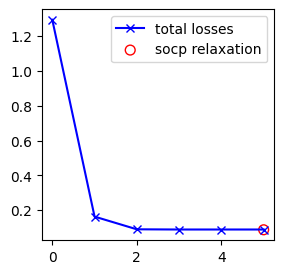

In [61]:
# fig, ax1 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)

# ax1.plot(range(total_num_iters), p_solution_over_iters[:,0], label=r'$P_0$', marker='^', ls='-', color='blue')
# ax1.plot(range(total_num_iters), p_solution_over_iters[:,1], label=r'$P_1$', marker='s', ls='--', color='green')
# ax1.plot(range(total_num_iters), p_solution_over_iters[:,2], label=r'$P_2$', marker='D', ls='-.', color='red')
# ax1.plot(range(total_num_iters), np.ones(total_num_iters)*Pmax[1], label=r'$P_{1}^{\max}$', ls='--', color='green')
# ax1.plot(range(total_num_iters), np.ones(total_num_iters)*Pmax[2], label=r'$P_{2}^{\max}$', ls='--', color='red')
# # ax1.plot(range(total_num_iters), np.ones(total_num_iters)*Pmin[1], label=r'$P_{1}^{\min}$', ls='--', color='grey')
# ax1.legend()

# fig, ax2 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)
# ax2.plot(range(total_num_iters), q_solution_over_iters[:,0], label=r'$Q_0$', marker='^', ls='-', color='blue')
# ax2.plot(range(total_num_iters), q_solution_over_iters[:,1], label=r'$Q_1$', marker='s', ls='--', color='green')
# ax2.plot(range(total_num_iters), q_solution_over_iters[:,2], label=r'$Q_2$', marker='D', ls='-.', color='red')
# ax2.plot(range(total_num_iters), np.ones(total_num_iters)*Qmin[1], label=r'$Q_{1}^{\min}$', ls='--', color='green')
# ax2.plot(range(total_num_iters), np.ones(total_num_iters)*Qmin[2], label=r'$Q_{2}^{\min}$', ls='--', color='red')
# ax2.legend()

fig, ax3 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)
ax3.plot(range(total_num_iters), total_losses_over_iters, label='total losses', marker='x', ls='-', color='blue')
ax3.scatter([total_num_iters-1],[0.08740776446973797], label='socp relaxation', facecolors='none', edgecolors='red', s=50)
ax3.legend()


plt.show()

In [62]:
print(total_losses_over_iters)

[1.29374958 0.16302654 0.09009139 0.08895966 0.08896459 0.08896459]
